New York City Taxi and Limousine Commission data for Green Taxis:
This DS challenge is designed to evaluate your skills and intuition regarding a real world data problem.
Data set: New York City Taxi and Limousine Commission trip records
https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page
The yellow and green taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up
and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported
passenger counts.
We’ll use data from Green Taxis for December 2016.
Load data and analyze:
1. Characterize the data and comment about its quality
2. Explore and visualize the data e.g. a histogram of trip distance
3. Find interesting trip statistics grouped by hour
4. The taxi drivers want to know what kind of trip yields better tips. Can you build a model for them and explain the model?
5. Pick one of the options below
- (Option 1) Find an anomaly in the data and explain your findings.
- (Option 2) Visualize the data to help understand trip patterns

Please submit the result in the form of runnable notebooks or scripts. A link to GitHub or other code
repository would be great.

Please let us know if we need to do anything special to run your notebook (install packages, get extra
data etc.)

In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv('green_tripdata_2016-12.csv', index_col=False)

In [3]:
df2 = pd.read_csv('taxi_zone_lookup.csv', index_col=False)

## 1. Characterize the data and comment about its quality

In [4]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type
0,2,2016-12-01 00:00:54,2016-12-01 00:06:54,N,1,92,192,1,1.29,6.5,0.5,0.5,0.00,0.0,NaN,0.3,7.80,2,1
1,2,2016-12-01 00:52:41,2016-12-01 00:54:51,N,1,92,171,1,0.64,4.0,0.5,0.5,1.06,0.0,NaN,0.3,6.36,1,1
2,2,2016-12-01 00:10:39,2016-12-01 00:14:47,N,1,75,238,2,0.89,5.5,0.5,0.5,1.70,0.0,NaN,0.3,8.50,1,1
3,2,2016-12-01 00:12:16,2016-12-01 00:15:31,N,1,166,151,1,0.66,4.5,0.5,0.5,1.74,0.0,NaN,0.3,7.54,1,1
4,2,2016-12-01 00:29:22,2016-12-01 00:39:51,N,1,166,42,1,2.15,9.5,0.5,0.5,2.16,0.0,NaN,0.3,12.96,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224153,1,2016-12-31 23:00:16,2016-12-31 23:05:30,N,1,74,75,1,1.20,6.0,0.5,0.5,0.00,0.0,NaN,0.3,7.30,2,1
1224154,1,2016-12-31 23:00:20,2016-12-31 23:04:05,N,1,42,41,3,1.00,5.5,0.5,0.5,0.00,0.0,NaN,0.3,6.80,2,1
1224155,1,2016-12-31 23:00:08,2016-12-31 23:15:57,N,1,243,159,1,5.30,18.5,0.5,0.5,3.95,0.0,NaN,0.3,23.75,1,1
1224156,1,2016-12-31 23:00:00,2016-12-31 23:10:15,N,1,244,120,3,1.60,8.5,0.5,0.5,0.00,0.0,NaN,0.3,9.80,2,1


In [5]:
df.isna().sum().sort_values(ascending=False).head()

ehail_fee       1224158
VendorID              0
extra                 0
payment_type          0
total_amount          0
dtype: int64

In [9]:
# Remove column with missing values
df = df.drop(columns=['ehail_fee'])

The data consists of 1,224,158 rows and 19 columns and takes up 112 MB of disk space. At the onset the data appears to be quite clean. There is very little issue with missingness. Only one column, 'ehail_fee', has missing values and it is missing 100% so it makes sense to remove it. 

In [12]:
df[df['total_amount']<=0]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type
320,2,2016-12-01 00:44:08,2016-12-01 00:44:59,N,1,92,92,1,0.11,-2.5,-0.5,-0.5,0.0,0.0,-0.3,-3.8,2,1
525,2,2016-12-01 00:58:17,2016-12-01 01:06:08,N,1,7,7,1,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1
831,1,2016-12-01 00:59:48,2016-12-01 01:14:23,N,1,112,97,1,3.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
901,1,2016-12-01 00:36:10,2016-12-01 00:39:46,N,5,97,97,2,1.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2
1272,2,2016-12-01 01:03:25,2016-12-01 01:03:45,N,2,193,193,1,0.00,-52.0,0.0,-0.5,0.0,0.0,-0.3,-52.8,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1223557,1,2016-12-31 23:56:32,2016-12-31 23:56:35,N,1,49,49,1,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1223610,1,2016-12-31 23:49:26,2016-12-31 23:59:09,N,5,20,78,1,2.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2
1223795,1,2016-12-31 23:32:14,2016-12-31 23:34:46,N,5,116,42,2,0.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2
1223820,1,2016-12-31 23:29:01,2016-12-31 23:40:15,N,5,174,47,1,2.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2


Another issue with the data is that there appear to be a number of rows with 'total_amount' less than or equal to zero. These trips seem to be anomolous and also make sense to remove from the data. 

In [13]:
df = df[df['total_amount']>0]

Now if we engineer a feature 'duration' and visualize 'trip_distance' vs. 'duration' we will see that there are a large number of outliers for duration. These are likely due to trips with improperly recorded pickup or dropoff times, possibly due to reseting the clock. Trips longer than 10,000 seconds (~2.78 hours) are atypically long for cab rides, so we will remove those as well. 

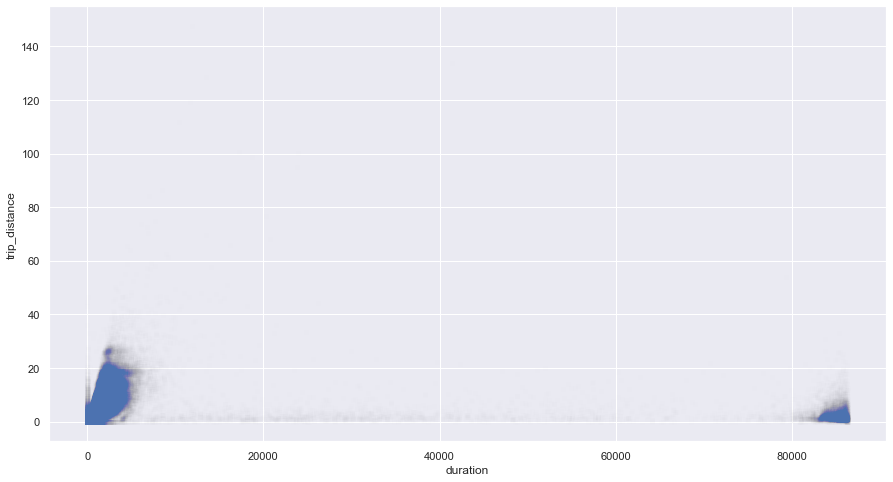

In [16]:
sns.set(rc = {'figure.figsize':(15,8)})
df['duration'] = (pd.to_datetime(df['lpep_dropoff_datetime']) - pd.to_datetime(df['lpep_pickup_datetime'])).dt.seconds
plt = sns.scatterplot(data=df, x="duration", y="trip_distance", alpha=0.002)

In [17]:
df = df[df['duration']<10000]

Before moving on to the next section we will engineer a few more features to aid in the analysis. 

In [20]:
# add hour from lpep_pickup_datetime and lpep_dropoff_datetime
df['pickup_hour'] = pd.DatetimeIndex(df['lpep_pickup_datetime']).hour
df['dropoff_hour'] = pd.DatetimeIndex(df['lpep_dropoff_datetime']).hour

In [21]:
# Add Borough for PULocationID
df = pd.merge(df, df2, left_on='PULocationID', right_on='LocationID').drop(columns=
                                ['LocationID', 'Zone', 'service_zone']).rename(columns={'Borough':'PUBorough'})
# Add Borough for DOLocationID
df = pd.merge(df, df2, left_on='DOLocationID', right_on='LocationID').drop(columns=                                           
                                ['LocationID', 'Zone', 'service_zone']).rename(columns={'Borough':'DOBorough'})

In [22]:
# Add Tip Percentage column
df['tip_perc'] = 100*df['tip_amount']/df['total_amount']

## 2. Explore and visualize the data e.g. a histogram of trip distance

(-1.0, 20.0)

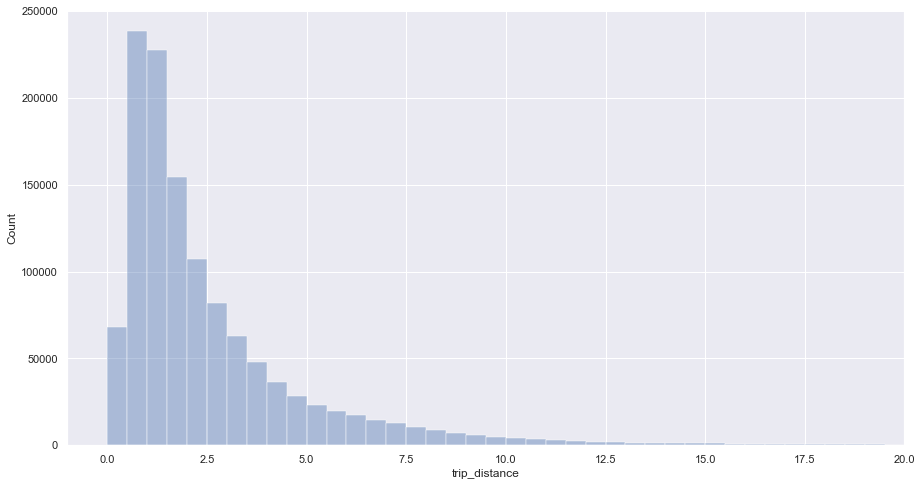

In [23]:
sns.set(rc = {'figure.figsize':(15,8)})
plt = sns.histplot(data=df, x="trip_distance", fill=True, common_norm=False, alpha=0.4, binwidth=0.5)
plt.set_xlim(-1, 20)

(0.0, 100.0)

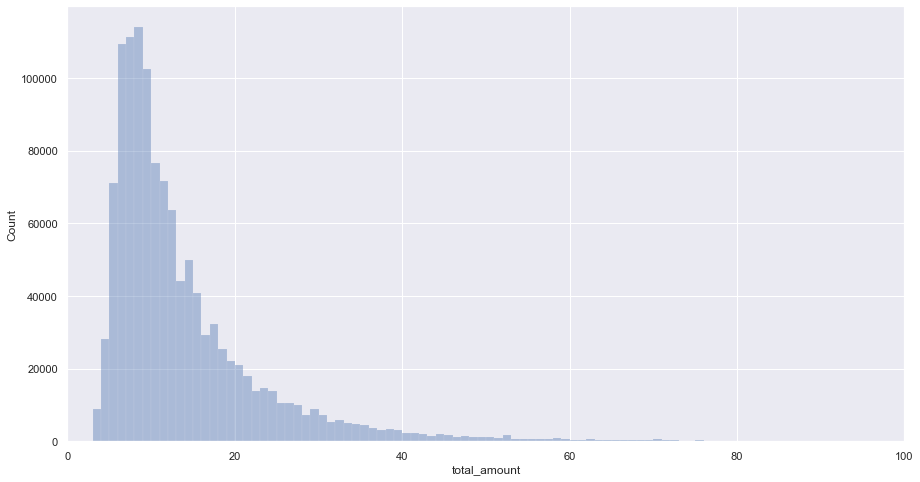

In [28]:
sns.set(rc = {'figure.figsize':(15,8)})
plt = sns.histplot(data=df, x="total_amount", fill=True, common_norm=False, alpha=0.4, binwidth=1)
plt.set_xlim(0, 100)

(0.0, 4000.0)

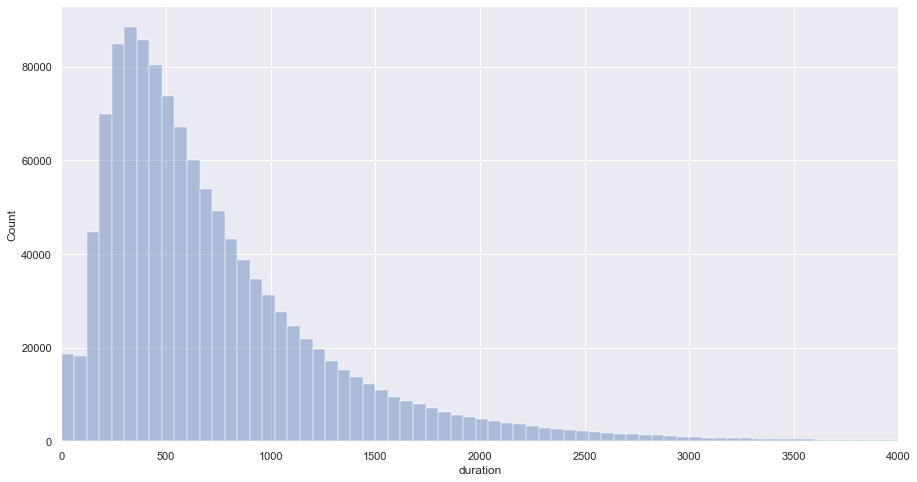

In [31]:
sns.set(rc = {'figure.figsize':(15,8)})
plt = sns.histplot(data=df, x="duration", fill=True, common_norm=False, alpha=0.4, binwidth=60)
plt.set_xlim(0, 4000)

(0.0, 10.0)

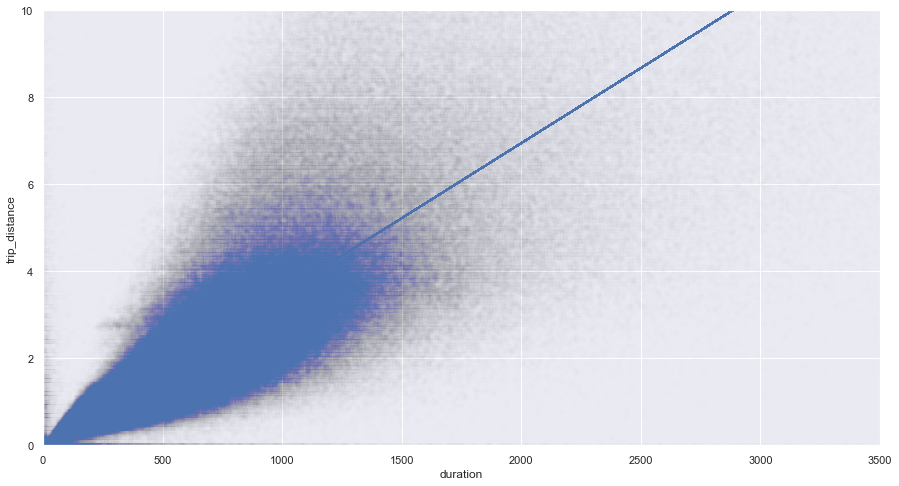

In [43]:
plt = sns.scatterplot(data=df, x="duration", y="trip_distance", alpha=0.002)
x = np.array(df['duration'])
y = np.array(df['trip_distance'])
a, b = np.polyfit(x, y, 1)
plt.plot(x, a*x+b)
plt.set_xlim(0, 3500)
plt.set_ylim(0, 10)

In [45]:
print(a*3600)
print(b)

12.42968666021196
0.04341377880385341


The average trip speed is 12.43 mph

## 3. Find interesting trip statistics grouped by hour

<AxesSubplot:xlabel='pickup_hour', ylabel='Count'>

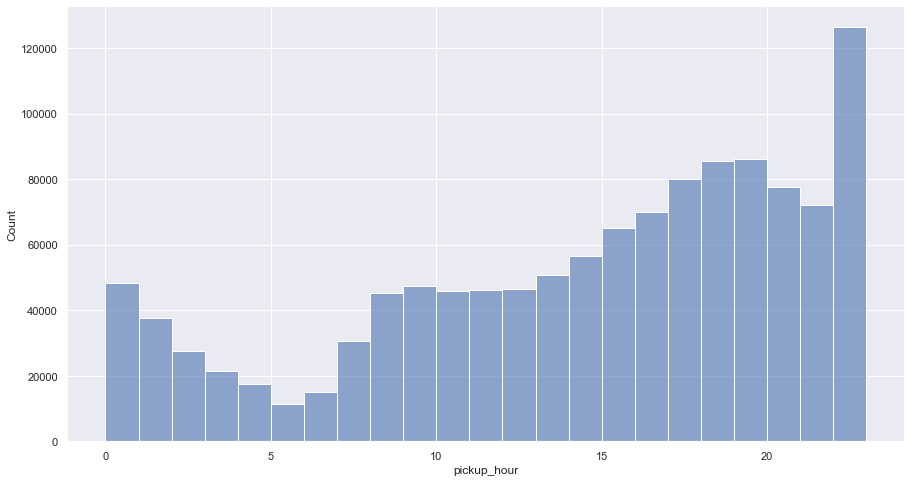

In [46]:
#Histogram of pickup_hour
sns.histplot(data=df, x="pickup_hour", fill=True, common_norm=False, alpha=0.6, binwidth=1)

There is a spike in the number of rides just before midnight possibly as the bars are closing and a low in the number of rides around 5 and 6am when most people are sleeping. 

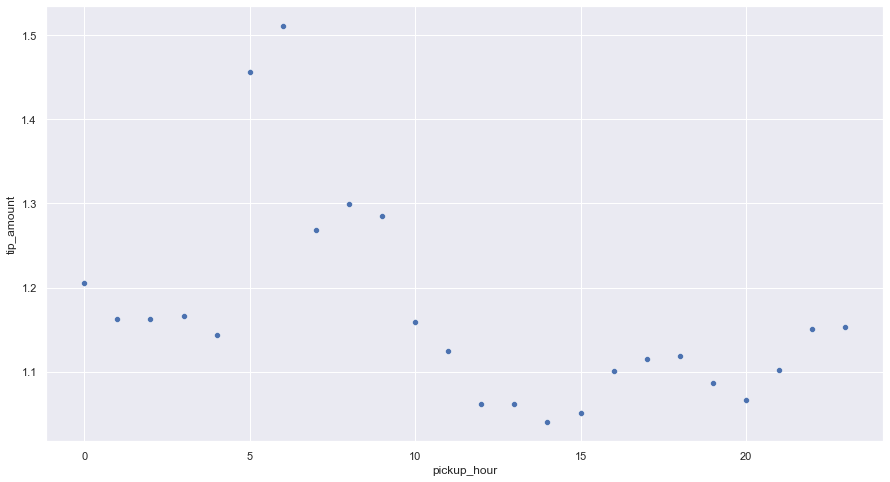

In [47]:
plt = sns.scatterplot(data=df.groupby('pickup_hour').mean()[['tip_amount']], x="pickup_hour", y="tip_amount")

There is also a spike in the tip amount around 5 and 6am, but is this actually a higher percentage or just that people are taking longer and more expensive trips around this time and leaving a similar percentage as usual? 

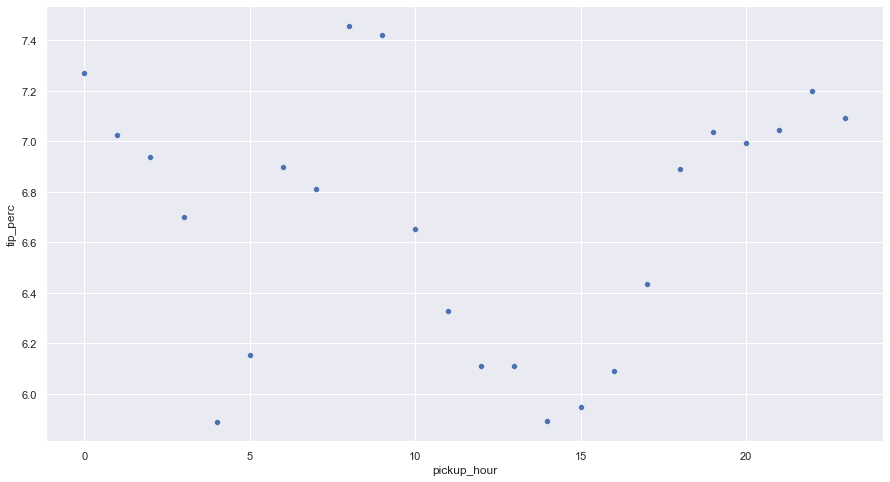

In [49]:
plt = sns.scatterplot(data=df.groupby('pickup_hour').mean()[['tip_perc']], x="pickup_hour", y="tip_perc")

It seems to be the latter. Tips at 5 and 6am are on par with those of other times in terms of the percentage. Although there is a slight dip in the tip percentages between 11am and 4pm. 

<AxesSubplot:xlabel='pickup_hour', ylabel='fare_amount'>

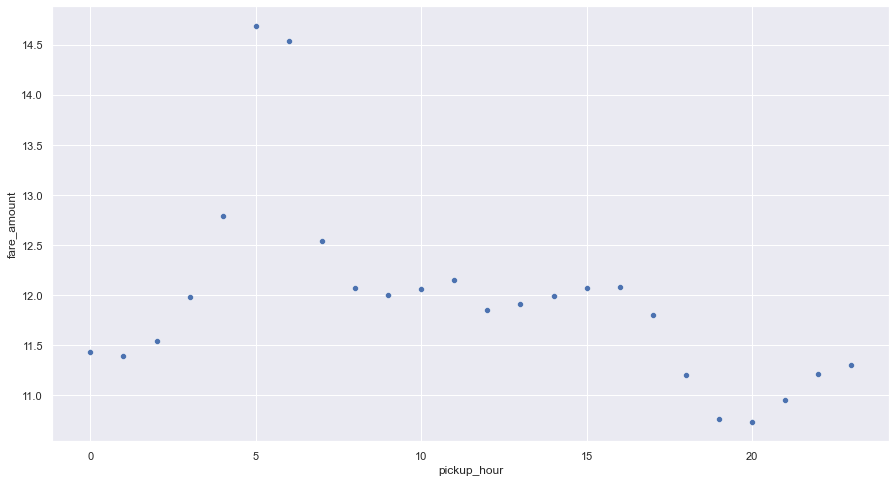

In [50]:
sns.scatterplot(data=df.groupby('pickup_hour').mean()[['fare_amount']], x="pickup_hour", y="fare_amount")

Rather it seems that people have more expensive and longer trips at 5 and 6am. This is likely corresponding to public transit becoming less available as the night goes on. 

<AxesSubplot:xlabel='pickup_hour', ylabel='trip_distance'>

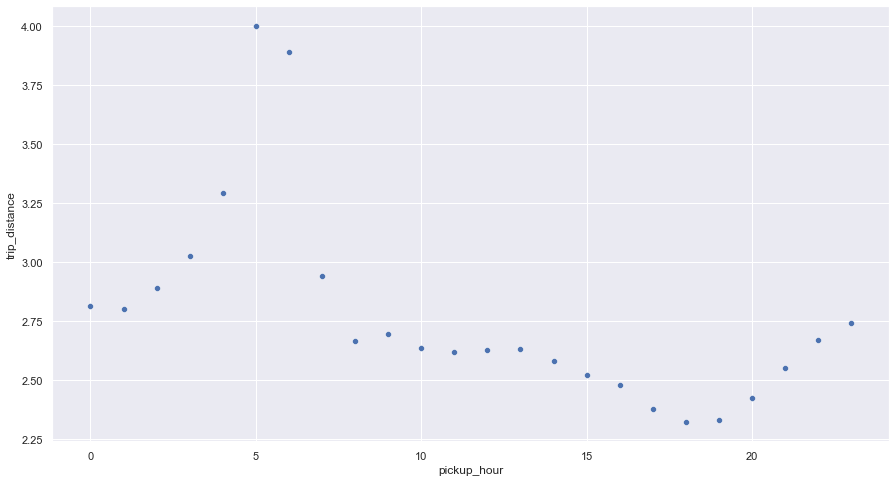

In [51]:
sns.scatterplot(data=df.groupby('pickup_hour').mean()[['trip_distance']], x="pickup_hour", y="trip_distance")

This phenomenon can also be seen in trip_distance vs. pickup_hour

## 4. The taxi drivers want to know what kind of trip yields better tips. Can you build a model for them and explain the model?

Let's do a little bit more data analysis before we build a model. Let's first look at the payment type for those people leaving tips.

(0.0, 0.03)

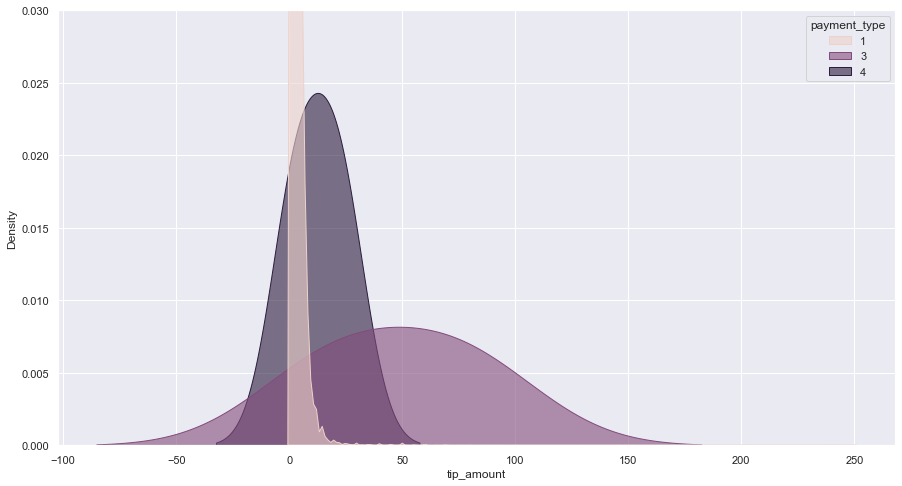

In [56]:
sns.set(rc = {'figure.figsize':(15,8)})
df_tips = df[df['tip_amount'] > 0]
plt = sns.kdeplot(data=df_tips, x="tip_amount", hue='payment_type', fill=True, common_norm=False, alpha=0.6)
plt.set_ylim(0, 0.03)

In [53]:
df_tips.groupby('payment_type').mean()[['tip_amount']]

,tip_amount
payment_type,
1,2.798952
3,48.500000
4,12.635000


- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute
- 5= Unknown
- 6= Voided trip

It seems that the only people leaving tips are those that pay with credit card. Trips that have no charge, or dispute also leave tips, and for those who left tips, the amounts are the greatest for the trips with no charge. 

In [54]:
df.groupby('payment_type').mean()[['tip_amount']]

,tip_amount
payment_type,
1,2.378398
2,0.000000
3,0.026294
4,0.010717
5,0.000000


However, it seems that there must be a large number of disputed and no charge trips that had no tips since if we include all trips, the average for these is quite low. 

(0.0, 0.2)

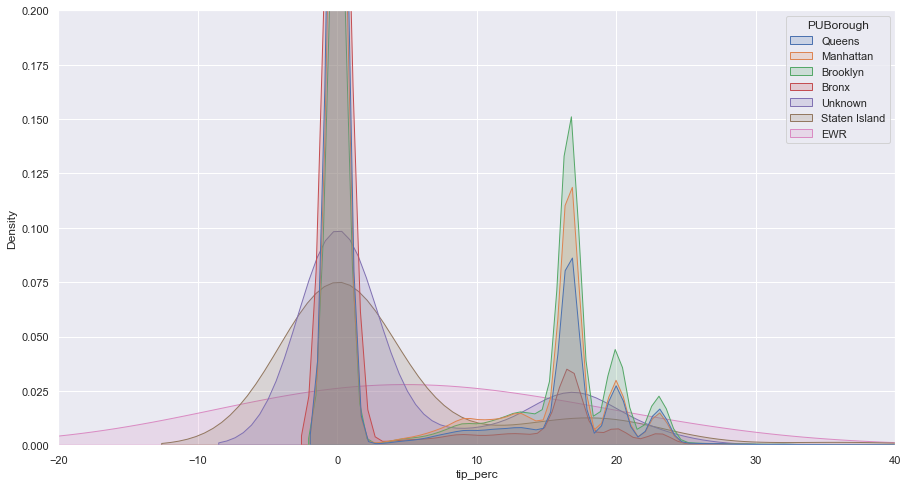

In [123]:
sns.set(rc = {'figure.figsize':(15,8)})
plt = sns.kdeplot(data=df, x="tip_perc", hue='PUBorough', fill=True, common_norm=False, alpha=0.2)
plt.set_xlim(-20, 40)
plt.set_ylim(0, 0.2)

From this density plot we can see that there are four major peaks in tip percentage. Around 0%, 18%, 20% and 22%. This are probably the default options for tip percentages when paying with a credit card. People picked up in Brooklyn seem to be the most likely to use these tip options. 

In [59]:
df.groupby('PUBorough').mean()[['tip_amount']]

,tip_amount
PUBorough,
Bronx,0.538351
Brooklyn,1.511146
EWR,9.400476
Manhattan,1.067292
Queens,0.833276
Staten Island,2.358785
Unknown,2.097724


In [63]:
df.groupby('PUBorough').mean()[['tip_perc']]

,tip_perc
PUBorough,
Bronx,2.807620
Brooklyn,8.668291
EWR,10.218711
Manhattan,6.502482
Queens,5.118879
Staten Island,4.705990
Unknown,6.097923


As shown in the two tables above, if we break down the tip amount and tip percentage by borough there is a clear difference. People picked up at Newark Airport tipped by far the most in both percentage and amount. Staten island left a large amount (likely due to the distance) but a smaller percentage. Pickups in Brooklyn yielded the second highest tip percentages followed by Manhattan, Queens, and Staten Island. Pickups in the Bronx yielded the worst average tips in both percentage and amount. 

Let's do some model building now. We'll start by selecting features that could be useful. 

In [64]:
df.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'payment_type', 'trip_type', 'duration', 'pickup_hour', 'dropoff_hour',
       'PUBorough', 'DOBorough', 'tip_perc'],
      dtype='object')

In [92]:
X = df[['RatecodeID', 'passenger_count', 'trip_distance', 'fare_amount', 'tolls_amount',
       'payment_type', 'trip_type', 'duration', 'pickup_hour',
       'PUBorough']]

In [93]:
y = df['tip_perc']

Let's build a random forest model first with label encoding, and then one-hot encoding. 

In [84]:
le = LabelEncoder()
X['PUBorough'] = le.fit_transform(X['PUBorough'])

/var/folders/rs/ck6nby4n2s365r7sdf740jt00000gn/T/ipykernel_57080/2152170123.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['PUBorough'] = le.fit_transform(X['PUBorough'])


In [85]:
X

,RatecodeID,passenger_count,trip_distance,fare_amount,tolls_amount,payment_type,trip_type,duration,pickup_hour,PUBorough
0,1,1,1.29,6.5,0.00,2,1,360,0,4
1,1,1,1.70,7.5,0.00,2,1,428,0,4
2,1,2,1.16,9.5,0.00,2,1,751,9,4
3,1,1,1.29,7.5,0.00,1,1,546,11,4
4,1,1,2.20,11.5,0.00,2,1,839,13,4
...,...,...,...,...,...,...,...,...,...,...
1210043,1,1,34.78,94.5,0.00,2,1,3922,7,4
1210044,1,1,0.00,8.5,0.00,1,1,766,4,5
1210045,5,1,6.07,24.0,0.00,2,2,646,6,5
1210046,1,1,14.90,50.0,11.08,1,1,3073,13,1


In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
model = ensemble.RandomForestRegressor()
model.fit(X_train, y_train)
print("The training r2: %.5f" % (model.score(X_train, y_train)))
print("The test     r2: %.5f" % (model.score(X_test, y_test)))

The training r2: 0.94402
The test     r2: 0.62207


<BarContainer object of 10 artists>

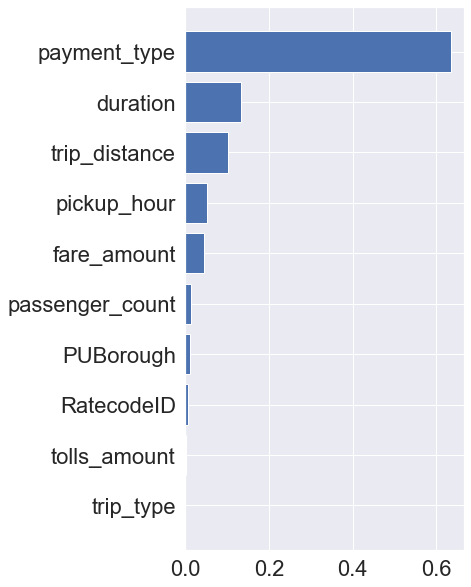

In [77]:
sorted_idx = model.feature_importances_.argsort()
sns.set(rc = {'figure.figsize':(5,10)})
sns.set(font_scale = 2)
plt.barh(X_test.columns[sorted_idx][:15], model.feature_importances_[sorted_idx][:15])

The algorithm tells us that payment type is the most important, which doesn't seem to be very useful for the driver since they don't have a lot of control over that. Let's try it again considering only credit card payments since cash tips are probably comparable, but not recorded. 

In [94]:
y = y[X['payment_type']==1]
X = X[X['payment_type']==1]
X = X.drop(columns = 'payment_type')

In [98]:
le = LabelEncoder()
X['PUBorough'] = le.fit_transform(X['PUBorough'])

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
model = ensemble.RandomForestRegressor()
model.fit(X_train, y_train)
print("The training r2: %.5f" % (model.score(X_train, y_train)))
print("The test     r2: %.5f" % (model.score(X_test, y_test)))

The training r2: 0.84781
The test     r2: -0.02829


<BarContainer object of 9 artists>

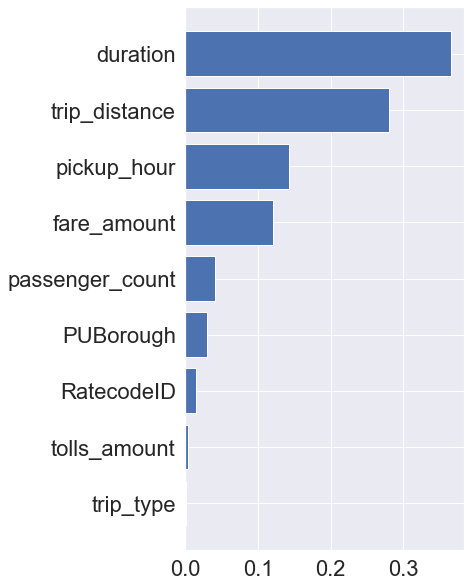

In [100]:
sorted_idx = model.feature_importances_.argsort()
sns.set(rc = {'figure.figsize':(5,10)})
sns.set(font_scale = 2)
plt.barh(X_test.columns[sorted_idx][:15], model.feature_importances_[sorted_idx][:15])

That didn't work very well. Let's try a model with one-hot-encoding. See if that does any better. 

In [101]:
X = df[['RatecodeID', 'passenger_count', 'trip_distance', 'fare_amount', 'tolls_amount',
       'payment_type', 'trip_type', 'duration', 'pickup_hour',
       'PUBorough']]
y = df['tip_perc']
y = y[X['payment_type']==1]
X = X[X['payment_type']==1]
X = X.drop(columns = 'payment_type')

In [103]:
X['RatecodeID'] = X['RatecodeID'].astype(str)
X['passenger_count'] = X['passenger_count'].astype(str)
X['trip_type'] = X['trip_type'].astype(str)
X = pd.get_dummies(X)
X

,trip_distance,fare_amount,tolls_amount,duration,pickup_hour,RatecodeID_1,RatecodeID_2,RatecodeID_3,RatecodeID_4,RatecodeID_5,...,passenger_count_9,trip_type_1,trip_type_2,PUBorough_Bronx,PUBorough_Brooklyn,PUBorough_EWR,PUBorough_Manhattan,PUBorough_Queens,PUBorough_Staten Island,PUBorough_Unknown
3,1.29,7.5,0.00,546,11,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
5,2.28,9.0,0.00,389,14,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
8,1.85,10.5,0.00,830,15,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
10,1.25,8.5,0.00,655,16,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
13,1.30,9.0,0.00,687,18,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1210037,7.30,23.5,2.08,1180,19,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1210041,18.83,50.5,11.08,1879,21,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1210042,23.00,67.5,11.08,3142,11,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1210044,0.00,8.5,0.00,766,4,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


The training r2: 0.84847
The test     r2: -0.03036


<BarContainer object of 15 artists>

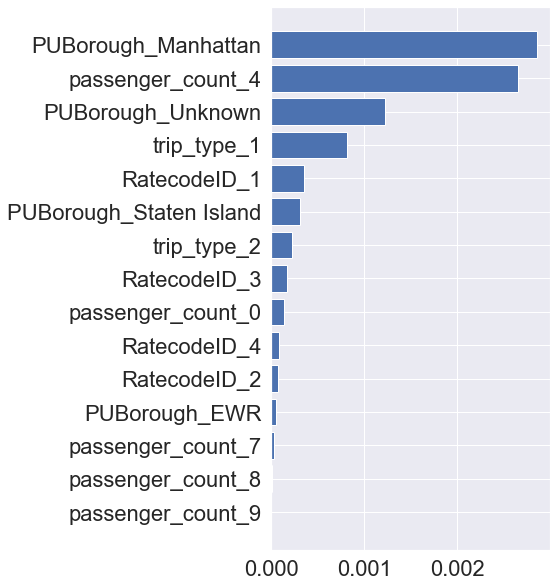

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
model = ensemble.RandomForestRegressor()
model.fit(X_train, y_train)
print("The training r2: %.5f" % (model.score(X_train, y_train)))
print("The test     r2: %.5f" % (model.score(X_test, y_test)))
sorted_idx = model.feature_importances_.argsort()
sns.set(rc = {'figure.figsize':(5,10)})
sns.set(font_scale = 2)
plt.barh(X_test.columns[sorted_idx][:15], model.feature_importances_[sorted_idx][:15])

And the same setup with a linear model...

In [105]:
mlr = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
mlr.fit(X_train, y_train)
print("The training r2: %.5f" % (mlr.score(X_train, y_train)))
print("The test     r2: %.5f" % (mlr.score(X_test, y_test)))

The training r2: 0.03560
The test     r2: 0.03520


Let's look at the relationship between duration and tips since that popped out in the list of highly important features.

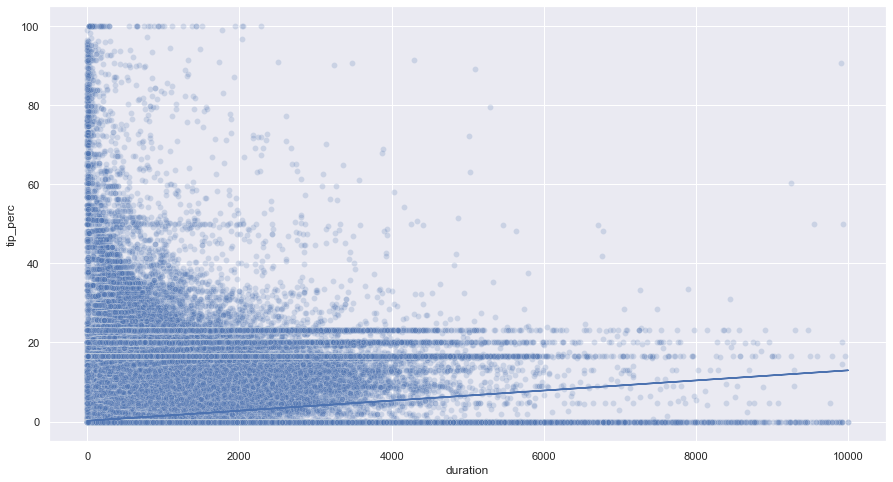

In [107]:
sns.set(rc = {'figure.figsize':(15,8)})
plt = sns.scatterplot(data=df, x="duration", y="tip_perc", alpha=0.2)
x = np.array(df['duration'])
y = np.array(df['tip_amount'])
a, b = np.polyfit(x, y, 1)
plt.plot(x, a*x+b)

Try catboost...

In [109]:
model = CatBoostRegressor(silent=True)
%time model.fit(X_train, y_train)
print("The training r2: %.5f" % (model.score(X_train, y_train)))
print("The test     r2: %.5f" % (model.score(X_test, y_test)))

CPU times: user 1min 4s, sys: 4.51 s, total: 1min 9s
Wall time: 13.3 s
The training r2: 0.12240
The test     r2: 0.08658


<BarContainer object of 15 artists>

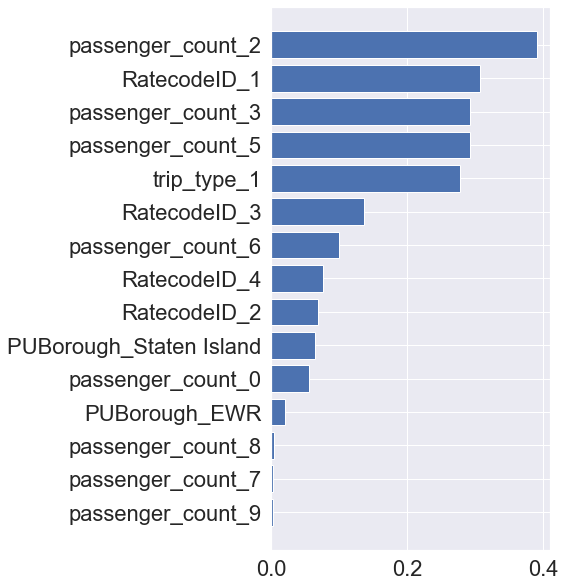

In [110]:
sorted_idx = model.feature_importances_.argsort()
sns.set(rc = {'figure.figsize':(5,10)})
sns.set(font_scale = 2)
plt.barh(X_test.columns[sorted_idx][:15], model.feature_importances_[sorted_idx][:15])

Now we could continue on and do some parameter tuning, but first let's take a step back and look at the data. 

In [113]:
df.groupby('payment_type').mean()[['tip_perc']]

,tip_perc
payment_type,
1,14.052215
2,0.000000
3,0.048612
4,0.042581
5,0.000000


In [115]:
df.groupby('RatecodeID').mean()[['tip_perc']]

,tip_perc
RatecodeID,
1,6.769222
2,7.627571
3,6.977785
4,5.910655
5,3.457522
6,0.000000


1= Standard rate 
2=JFK 
3=Newark 
4=Nassau or Westchester 
5=Negotiated fare 
6=Group ride 

It seems that there isn't a huge difference in tips from RatecodeID except that Negociated fares have lower tips. 

In [118]:
df.groupby('passenger_count').mean()[['tip_perc']]

,tip_perc
passenger_count,
0,7.124596
1,6.713853
2,6.627368
3,6.569562
4,6.064817
5,6.833225
6,7.223048
7,7.233321
8,3.468013


No significant difference depending on number of passengers either. Except 8 and 9 passengers leave horrible tips. Also not sure how 0 passengers can leave a tip. 

In [121]:
df.groupby('trip_type').mean()[['tip_perc']]

,tip_perc
trip_type,
1,6.772149
2,3.396044


- 1= Street-hail
- 2= Dispatch
- It seems that Street-hail trips pay twice the percentage of tips as Dispatch rides.  

In [122]:
df.groupby('PUBorough').mean()[['tip_perc']]

,tip_perc
PUBorough,
Bronx,2.807620
Brooklyn,8.668291
EWR,10.218711
Manhattan,6.502482
Queens,5.118879
Staten Island,4.705990
Unknown,6.097923


### In conclusion, while we couldn't build a reliable model to predict tip percentage, through EDA we were able to glean that those trips that yield higher percentage tips were those that we're Street-hailed, picked up in Brooklyn or EWR, in the early mornings and evening/night and with fewer than 8 passengers. For the most part, the tip percentages people left seemed to be fairly constant. In future work we would spend some time tuning the hyperparameters of the models to see if we can do any better.

## 5. Pick one of the options below
### - (Option 1) Find an anomaly in the data and explain your findings.
### - (Option 2) Visualize the data to help understand trip patterns

I believe I've done both of these things in previous sections.

## We trained a few more models on tip_amount rather than trip_perc. These also included payment_type and non-credit card payment types which didn't include tips. These models do reasonably well, but seem to be mostly operating on whether or not credit card was used. 

In [133]:
X = df[['RatecodeID', 'passenger_count', 'trip_distance', 'fare_amount', 'tolls_amount',
       'payment_type', 'trip_type', 'duration', 'pickup_hour',
       'PUBorough']]
le = LabelEncoder()
X_le = X.copy()
X_le['PUBorough'] = le.fit_transform(X_le['PUBorough'])
X_ohe = X.copy()
X_ohe['RatecodeID'] = X_ohe['RatecodeID'].astype(str)
X_ohe['passenger_count'] = X_ohe['passenger_count'].astype(str)
X_ohe['trip_type'] = X_ohe['trip_type'].astype(str)
X_ohe['payment_type'] = X_ohe['payment_type'].astype(str)
X_ohe = pd.get_dummies(X_ohe)
y = df['tip_amount']

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X_le, y, test_size = 0.25)
model = CatBoostRegressor(silent=True)
%time model.fit(X_train, y_train)
print("The training r2: %.5f" % (model.score(X_train, y_train)))
print("The test     r2: %.5f" % (model.score(X_test, y_test)))
sorted_idx = model.feature_importances_.argsort()
sns.set(rc = {'figure.figsize':(5,10)})
sns.set(font_scale = 2)
plt.barh(X_test.columns[sorted_idx][:15], model.feature_importances_[sorted_idx][:15])

CPU times: user 2min 20s, sys: 5.65 s, total: 2min 25s
Wall time: 26.1 s
The training r2: 0.61336
The test     r2: 0.51128


<BarContainer object of 10 artists>

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X_ohe, y, test_size = 0.25)
model = CatBoostRegressor(silent=True)
%time model.fit(X_train, y_train)
print("The training r2: %.5f" % (model.score(X_train, y_train)))
print("The test     r2: %.5f" % (model.score(X_test, y_test)))
sorted_idx = model.feature_importances_.argsort()
sns.set(rc = {'figure.figsize':(5,10)})
sns.set(font_scale = 2)
plt.barh(X_test.columns[sorted_idx][:15], model.feature_importances_[sorted_idx][:15])

CPU times: user 2min 20s, sys: 5.43 s, total: 2min 25s
Wall time: 25.4 s
The training r2: 0.61110
The test     r2: 0.48636


<BarContainer object of 15 artists>

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X_le, y, test_size = 0.25)
model = ensemble.RandomForestRegressor()
%time model.fit(X_train, y_train)
print("The training r2: %.5f" % (model.score(X_train, y_train)))
print("The test     r2: %.5f" % (model.score(X_test, y_test)))
sorted_idx = model.feature_importances_.argsort()
sns.set(rc = {'figure.figsize':(5,10)})
sns.set(font_scale = 2)
plt.barh(X_test.columns[sorted_idx][:15], model.feature_importances_[sorted_idx][:15])

CPU times: user 2min 24s, sys: 1.55 s, total: 2min 26s
Wall time: 2min 27s
The training r2: 0.92463
The test     r2: 0.47409


<BarContainer object of 10 artists>

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X_ohe, y, test_size = 0.25)
model = ensemble.RandomForestRegressor()
%time model.fit(X_train, y_train)
print("The training r2: %.5f" % (model.score(X_train, y_train)))
print("The test     r2: %.5f" % (model.score(X_test, y_test)))
sorted_idx = model.feature_importances_.argsort()
sns.set(rc = {'figure.figsize':(5,10)})
sns.set(font_scale = 2)
plt.barh(X_test.columns[sorted_idx][:15], model.feature_importances_[sorted_idx][:15])

CPU times: user 3min 10s, sys: 1.6 s, total: 3min 11s
Wall time: 3min 12s
The training r2: 0.92387
The test     r2: 0.49374


<BarContainer object of 15 artists>